In [172]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import matplotlib.pyplot as plt
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np

In [173]:
df = pd.read_excel('Ticket Samples and Summary.xlsx')

#output - classifications
#input - subject, ticket description

col = ['Classifications', 'Subject']
df = df[col]
df = df[pd.notnull(df['Classifications'])]
df.columns = ['Classifications', 'Subject']
df['category_id'] = df['Classifications'].factorize()[0]
category_id_df = df[['Classifications', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Classifications']].values)
df.head(17)


,Classifications,Subject,category_id
0,General Clarification,VitalDx log in,0
1,Incident,Route3-Capstone UTI - LIS Results failure,1
2,General Clarification,PPMG Claims Purging Details - collect.vitalaxi...,0
3,General Clarification,Voicemail Message (DDL > VitAxis Support) From...,0
4,Incident,P4C.VA-IMP.Orders.Inbound.IMP2P4 Failure,1
5,General Clarification,Build in THX tomorrow,0
6,Service Request,Troy's Genus3 VitalDx login,2
7,Incident,Adjust label settings,1
8,Service Request,P4 Diagnostix - Patient Results,2
9,Service Request,Capstone - Newly created ordering physicians a...,2


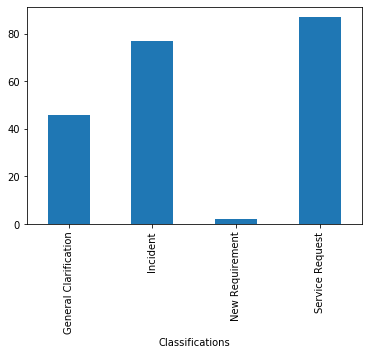

Service Request          87
New Requirement          82
Incident                 77
General Clarification    46
Name: Classifications, dtype: int64

In [174]:
fig = plt.figure()
df.groupby('Classifications').Subject.count().plot.bar(ylim=0)
plt.show()

new_req = df['Classifications'] == 'New Requirement'
df_try = df[new_req]
df = df.append([df_try]*40, ignore_index = True)

df['Classifications'].value_counts()

In [175]:
general = df['Classifications'] == 'General Clarification'
df_try = df[general]
df = df.append([df_try], ignore_index = True)

df['Classifications'].value_counts()

General Clarification    92
Service Request          87
New Requirement          82
Incident                 77
Name: Classifications, dtype: int64

In [176]:
tfidf = TfidfVectorizer(sublinear_tf = True, min_df = 6, norm = 'l2', encoding='utf-8', ngram_range=(1,2), stop_words='english')
features = tfidf.fit_transform(df.Subject).toarray()
labels = df.category_id
features.shape

(338, 48)

In [177]:
N = 2
for Classifications, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Classifications))
    print("  . Most correlated unigrams:\n. {}".format('\n.'.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n.'.join(bigrams[-N:])))
    

# 'General Clarification':
  . Most correlated unigrams:
. print
.issue
  . Most correlated bigrams:
. print report
.auto print
# 'Incident':
  . Most correlated unigrams:
. inbound
.failure
  . Most correlated bigrams:
. inbound failure
.outbound failure
# 'New Requirement':
  . Most correlated unigrams:
. auto
.print
  . Most correlated bigrams:
. print report
.auto print
# 'Service Request':
  . Most correlated unigrams:
. reset
.password
  . Most correlated bigrams:
. print report
.password reset


In [178]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['Subject'], df['Classifications'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [179]:
print(clf.predict(count_vect.transform(["Getting file is corrupt message "])))

['Incident']


C:\Users\Nitya\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Nitya\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Nitya\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Nitya\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Nitya\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default so

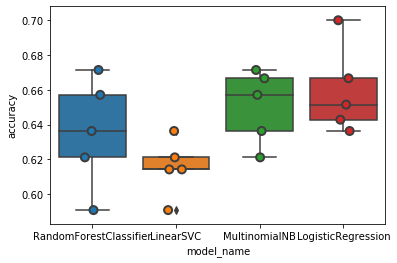

In [180]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()


In [181]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.615411
LogisticRegression        0.659481
MultinomialNB             0.650563
RandomForestClassifier    0.635411
Name: accuracy, dtype: float64

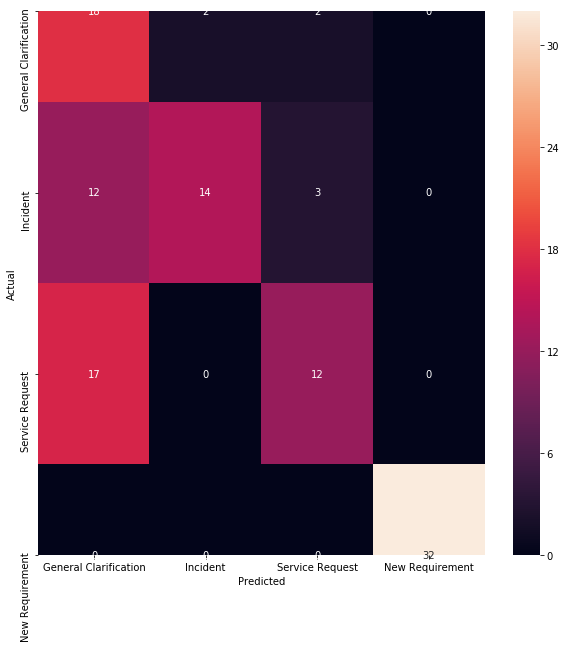

In [182]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Classifications.values, yticklabels=category_id_df.Classifications.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [183]:
from IPython.display import display
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Classifications', 'Subject']])
      print('')

'Incident' predicted as 'General Clarification' : 12 examples.


,Classifications,Subject
158,Incident,VCDFT failures ( MESSAGE AUDIT FAILED )
200,Incident,Reports with no data
54,Incident,Screening type is wrong - SEV 1 - FWC
167,Incident,Thunderbolt COVID testing
78,Incident,REPORTING ISSUE
135,Incident,Issues with assigning accession # to NJU eOrdres
136,Incident,Issues with assigning accession # to NJU eOrdres
7,Incident,Adjust label settings
122,Incident,(No Subject)
102,Incident,Error while attempting to order in a new acct



'Service Request' predicted as 'General Clarification' : 17 examples.


,Classifications,Subject
64,Service Request,Product Backlog Item 18490: Display Received D...
198,Service Request,Urgent
59,Service Request,L2L result failures
26,Service Request,Unlock login id
173,Service Request,xxxxxx - accession #
63,Service Request,VC Slow
179,Service Request,Pittsburgh Gastro Associates - VitalDesktop er...
171,Service Request,Dr. Trenkle
92,Service Request,Digestive Disease Associates
49,Service Request,Delete Accession


In [184]:
model.fit(features, labels)
N = 2
for Classifications, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Classifications))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'General Clarification':
  . Top unigrams:
       . auto
       . issue
  . Top bigrams:
       . voicemail message
       . vitaxis support
# 'Incident':
  . Top unigrams:
       . problem
       . failure
  . Top bigrams:
       . results outbound
       . outbound failure
# 'New Requirement':
  . Top unigrams:
       . print
       . req
  . Top bigrams:
       . print report
       . auto print
# 'Service Request':
  . Top unigrams:
       . password
       . 05
  . Top bigrams:
       . password reset
       . voicemail message


In [185]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Classifications'].unique()))

                       precision    recall  f1-score   support

General Clarification       0.38      0.82      0.52        22
             Incident       0.88      0.48      0.62        29
      Service Request       0.71      0.41      0.52        29
      New Requirement       1.00      1.00      1.00        32

             accuracy                           0.68       112
            macro avg       0.74      0.68      0.67       112
         weighted avg       0.77      0.68      0.68       112

